In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### **Dataset**

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

--2024-10-08 21:13:10--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298573 (292K) [text/plain]
Saving to: 'laptops.csv.3'

     0K .......... .......... .......... .......... .......... 17%  162K 1s
    50K .......... .......... .......... .......... .......... 34%  163K 1s
   100K .......... .......... .......... .......... .......... 51% 5.05M 1s
   150K .......... .......... .......... .......... .......... 68%  256K 0s
   200K .......... .......... .......... .......... .......... 85% 61.2K 0s
   250K .......... .......... .......... .......... .         100% 16.0M=1.6s

2024-10-08 21:13:13 (178 KB/s) - 'laptops.csv.3' saved [298573/298573]



### **Preparing the dataset**

In [3]:
df = pd.read_csv('laptops.csv')
df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

df = df[['ram', 'storage', 'screen', 'final_price']]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ram          2160 non-null   int64  
 1   storage      2160 non-null   int64  
 2   screen       2156 non-null   float64
 3   final_price  2160 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 67.6 KB


### **EDA**

Look at the final_price variable. Does it have a long tail?

<Axes: xlabel='final_price', ylabel='Count'>

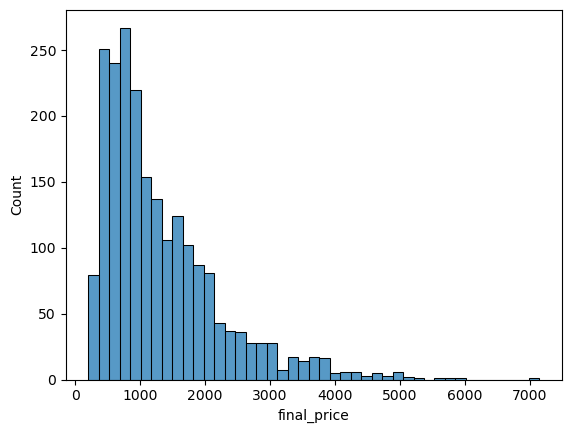

In [6]:
sns.histplot(data=df, x='final_price')

### **Question 1**

There's one column with missing values. What is it?

In [7]:
missing_columns = df.columns[df.isnull().any()][0]
print(f"{missing_columns} column has missing values")

screen column has missing values


### **Question 2**

What's the median (50% percentile) for variable 'ram'?

In [8]:
median_ram = np.median(df['ram'])
print(f"The median of ram variable is {median_ram}")

The median of ram variable is 16.0


### **Prepare and split the dataset**

- Shuffle the dataset (the filtered one you created above), use seed 42.
- Split your data in train/val/test sets, with 60%/20%/20% distribution

In [9]:
n = df.shape[0]
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

assert n == n_train + n_val + n_test

In [10]:
print(n, n_train, n_val, n_test)

2160 1296 432 432


In [11]:
idx = np.arange(n)

np.random.seed(42)
np.random.shuffle(idx)

In [12]:
df_train = df.iloc[idx[:n_train]].reset_index(drop=False)
df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=False)
df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=False)

In [13]:
assert df.shape[0] == df_train.shape[0] + df_val.shape[0] + df_test.shape[0]

### **Question 3**

- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

In [14]:
mean_train_screen = df_train['screen'].mean()

def prepare_X(df, impute_na=0):
    df = df.copy()
    df['screen'] = df['screen'].fillna(impute_na)
    X = df.iloc[:, :-1].values

    return X

X_train_zero = prepare_X(df_train)
X_train_mean = prepare_X(df_train, impute_na=mean_train_screen)
y_train = df_train.iloc[:, -1].values

X_val_zero = prepare_X(df_val)
X_val_mean = prepare_X(df_val, impute_na=mean_train_screen)
y_val = df_val.iloc[:, -1].values

X_test_zero = prepare_X(df_test)
X_test_mean = prepare_X(df_test, impute_na=mean_train_screen)
y_test = df_test.iloc[:, -1].values


In [15]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    rmse = round(np.sqrt(mse), 2)
    return rmse

In [16]:
w0, w = train_linear_regression(X_train_zero, y_train)
y_pred_zero = w0 + X_val_zero.dot(w)
rmse_zero = rmse(y_val, y_pred_zero)

print(f"RMSE for model with imputed null value with zero values: {rmse_zero}")

RMSE for model with imputed null value with zero values: 598.31


In [17]:
w0, w = train_linear_regression(X_train_mean, y_train)
y_pred_mean = w0 + X_val_mean.dot(w)
rmse_mean = rmse(y_val, y_pred_mean)

print(f"RMSE for model with imputed null value with mean of training value: {rmse_mean}")

RMSE for model with imputed null value with mean of training value: 601.4


### **Question 4**

- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?

In [18]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [19]:
rmse_scores = {}
list_r = [0, 0.01, 0.1, 1, 5, 10, 100]

for r in list_r:
    w0, w = train_linear_regression_reg(X_train_zero, y_train, r)
    y_pred_zero = w0 + X_val_zero.dot(w)
    rmse_zero = rmse(y_val, y_pred_zero)
    rmse_scores[r] = rmse_zero

best_r = min(rmse_scores.items(), key=lambda k: k[1])[0]
print(f"Best r value based on the minimum RMSE: {best_r}")

Best r value based on the minimum RMSE: 10


### **Question 5**

- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
- Round the result to 3 decimal digits (round(std, 3))

What's the value of std?

In [20]:
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_scores = []

for s in seed_values:
    idx = np.arange(n)
    np.random.seed(s)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]].reset_index(drop=False)
    df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=False)
    df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=False)

    X_train_zero = prepare_X(df_train)
    y_train = df_train.iloc[:, -1].values

    X_val_zero = prepare_X(df_val)
    y_val = df_val.iloc[:, -1].values

    X_test_zero = prepare_X(df_test)
    y_test = df_test.iloc[:, -1]
    
    w0, w = train_linear_regression(X_train_zero, y_train)
    y_pred_zero = w0 + X_val_zero.dot(w)
    rmse_zero = rmse(y_val, y_pred_zero)

    rmse_scores.append(rmse_zero)

std_rmse = round(np.std(rmse_scores), 3)
print(f"The standard deviation across RMSE scores: {std_rmse}")

The standard deviation across RMSE scores: 28.994


### **Question 6**

- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.
- What's the RMSE on the test dataset?

In [21]:
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

df_full_train = df.iloc[idx[:n_train+n_val]].reset_index(drop=False)
df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=False)

X_train = prepare_X(df_full_train)
y_train = df_full_train.iloc[:, -1].values

X_test = prepare_X(df_test)
y_test = df_test.iloc[:, -1].values

w0, w = train_linear_regression_reg(X_train, y_train, r=0.001)
y_pred = w0 + X_test.dot(w)
rmse_model = rmse(y_test, y_pred)


print(f"The RMSE of the model: {rmse_model}")

The RMSE of the model: 609.66
